# Boston House Price Forecast




## **1 Introduction**

## **2 Experiment Code**

### **2.1 Introducing Dependencies**

In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns

mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

### **2.2 Loading the Data Set, Viewing Data Attributes, and Visualizing the Data**

#### **Step 1: Load the Boston house price data set and display related attributes.**

In [16]:
# Load the Boston house price data set.
housing = fetch_california_housing()

# x features, and y labels.
x = housing.data
y = housing.target

# Display related attributes.
print('Feature column name')
print(housing.feature_names)
print("Sample data volume: %d, number of features: %d" % x.shape)
print("Target sample data volume: %d" % y.shape[0])

Feature column name
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Sample data volume: 20640, number of features: 8
Target sample data volume: 20640


#### **Step 2: Convert to the dataframe format.**

In [17]:
x = pd.DataFrame(housing.data, columns=housing.feature_names)
x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


#### **Step 3: Visualize label distribution.**

<Axes: >

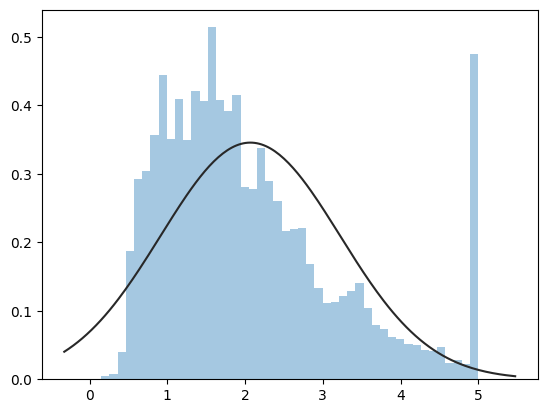

In [18]:
sns.distplot(tuple(y), kde=False, fit=st.norm)

### **2.3 Spliting and Pre-processing the Data Set**

In [19]:
# Segment the data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)

# Standardize the data set.
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)
x_train[0:100]

array([[ 2.28655275e+00, -1.00374733e+00,  7.31500047e-01,
        -2.81832382e-01,  7.21872633e-02, -1.31009118e-03,
         7.44083934e-01, -1.15694555e+00],
       [ 1.57815957e+00,  1.06417939e+00,  3.90085610e-01,
        -1.14864509e-01, -6.96366263e-01, -1.93935864e-02,
        -7.89623345e-01,  7.17671737e-01],
       [-1.39683848e+00,  6.66501172e-01, -9.84306177e-01,
        -2.14063931e-02, -1.08020285e+00, -2.14451570e-02,
        -7.05456482e-01,  6.57683983e-01],
       [ 3.41110040e-01,  5.86965529e-01,  3.62219838e-01,
        -7.97178674e-02, -2.15690175e-01,  3.70791995e-03,
        -7.98975219e-01,  1.07259928e+00],
       [ 6.70720655e-02, -1.16281861e+00, -3.34131833e-01,
        -9.77395308e-02,  1.54062630e+00, -2.46192640e-02,
        -8.92493955e-01,  8.27649284e-01],
       [-1.33472743e+00, -4.46997826e-01, -8.69394784e-01,
        -7.19716937e-02, -7.48327126e-02, -5.49312178e-02,
        -7.61567724e-01,  7.37667654e-01],
       [ 6.12140088e-01,  2.688229

### **2.4 Using Various Regression Models to Model Data Sets**

In [20]:
# Set the model name.
names = ['LinerRegression',
         'Ridge',
         'Lasso',
         'Random Forest',
         'GBDT',
         'Support Vector Regression',
         'ElasticNet',
         'XgBoost']

# Define the model.
# cv is the cross-validation idea here.
models = [LinearRegression(),
          RidgeCV(alphas=(0.001, 0.1, 1), cv=3),
    LassoCV(alphas=(0.001, 0.1, 1), cv=5),
    RandomForestRegressor(n_estimators=10),
    GradientBoostingRegressor(n_estimators=30),
    SVR(),
    ElasticNet(alpha=0.001, max_iter=10000),
    XGBRegressor()]

# Output the R2 scores of all regression models.
# Define the R2 scoring function.
def R2(model, x_train, x_test, y_train, y_test):

    model_fitted = model.fit(x_train, y_train)
    y_pred = model_fitted.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

# Traverse all models to score.
for name, model in zip(names, models):
    score = R2(model, x_train, x_test, y_train, y_test)
    print("{}: {:.6f}".format(name, score.mean()))

LinerRegression: 0.625378
Ridge: 0.625379
Lasso: 0.625060
Random Forest: 0.799582
GBDT: 0.716641
Support Vector Regression: 0.749270
ElasticNet: 0.625223
XgBoost: 0.838579


### **2.5 Adjusting Hyperparameters by Grid Search**

#### **Step 1: Build a model.**


In [25]:
'''
 'kernel': kernel function
 'C': SVR regularization factor
 'gamma': 'rbf', 'poly' and 'sigmoid' kernel function coefficient, which affects the model performance
'''
parameters = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 0.5,0.9,1,5],
              'gamma': [0.001,0.01,0.1,1]
             }

#Use grid search and perform cross validation.
model = GridSearchCV(SVR(), param_grid=parameters, cv=3)
model.fit(x_train, y_train)


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.1, 0.5, 0.9, 1, 5],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']})

#### **Step 2: Obtain optimal parameters.**

In [26]:
print("Optimal parameter list:", model.best_estimator_.get_params())
print("Optimal model:", model.best_estimator_)
print("Optimal R2 value:", model.best_score_)

Optimal parameter list: {'C': 5, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Optimal model: SVR(C=5, gamma=1)
Optimal R2 value: 0.7515772615928471


#### **Step 3: Perform visualization.**

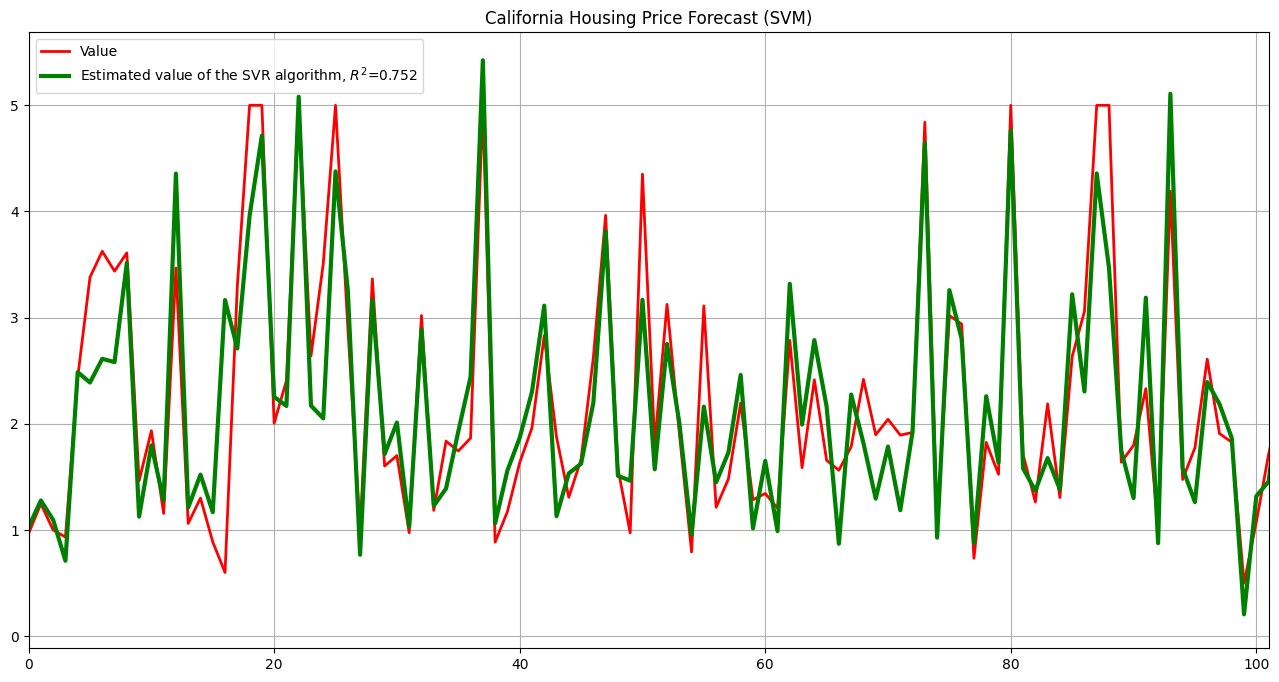

In [29]:
##Perform visualization.
ln_x_test = range(len(x_test))
y_predict = model.predict(x_test)

#Set the canvas.
plt.figure(figsize=(16,8), facecolor='w')

#Draw with a red solid line.
plt.plot (ln_x_test, y_test, 'r-', lw=2, label=u'Value')

#Draw with a green solid line.
plt.plot (ln_x_test, y_predict, 'g-', lw = 3, label=u'Estimated value of the SVR algorithm, $R^2$=%.3f' %
(model.best_score_))

#Display in a diagram.
plt.legend(loc ='upper left')
plt.grid(True)
plt.title(u"California Housing Price Forecast (SVM)")
plt.xlim(0, 101)
plt.show()
